# Классификация комментариев интернет-магазина

## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

- Необходимо построить модель со значением метрики *F-1* не меньше 0.75. 

**Исходные данные**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**Этапы проекта**

1. Загрузим и подготовим данные.
2. Обучим разные модели. 
3. Сделаем выводы.

## Загрузка данных

### Подготовка библиотек и загрузка данных

In [1]:
## импортируем необходимые библиотеки----------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re 
import nltk
import spacy

## из библиотек импортируем необходимые функции и классы---------------------------------
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# загружаем инструменты для автоподбора гиперпараметров
from sklearn.model_selection import (
    GridSearchCV, 
)

# загружаем классы моделей
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier

# загружаем класс для работы с пайплайнами
from sklearn.pipeline import Pipeline

# загружаем метрики
from sklearn.metrics import f1_score

## константы----------------------------------------------------------------------------

# константа для фиксации данных при обучении моделей, чтобы получать одинаковые результаты при пересчёте
RANDOM_STATE = 42  

# размер тестовой выборки
TEST_SIZE = 0.25   

## настройки----------------------------------------------------------------------------

# скрываем предупреждения
warnings.filterwarnings('ignore')

Cоздадим датафрейм `df` из файла `toxic_comments.csv`.

In [2]:
# загружаем данные заказчика, удаляем старые индексы "Unnamed:"" 0 и назначаем новые
df = pd.read_csv('toxic_comments.csv', index_col=0).reset_index(drop=True)

- Данные загружены в датафрейм.
- Ошибок не обнаружено.

### Получение общей информации о данных

In [3]:
# получим общую информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
# выведем первые и последние строки датафрейма
print(df.head())
print(df.tail())

                                                text  toxic
0  Explanation\nWhy the edits made under my usern...      0
1  D'aww! He matches this background colour I'm s...      0
2  Hey man, I'm really not trying to edit war. It...      0
3  "\nMore\nI can't make any real suggestions on ...      0
4  You, sir, are my hero. Any chance you remember...      0
                                                     text  toxic
159287  ":::::And for the second time of asking, when ...      0
159288  You should be ashamed of yourself \n\nThat is ...      0
159289  Spitzer \n\nUmm, theres no actual article for ...      0
159290  And it looks like it was actually you who put ...      0
159291  "\nAnd ... I really don't think you understand...      0


In [5]:
#проверим данные на полные дубликаты
df.duplicated().sum()

0

In [6]:
# проверим столбец 'text' на дубликаты
df['text'].duplicated().sum()

0

Дубликаты не обнаружены.

Выведем количество токсичных и нетоксичных комментариев.

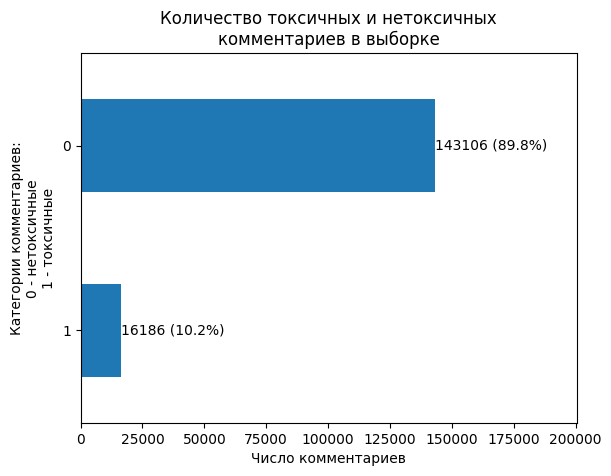

In [7]:
data=df['toxic'].value_counts().sort_values(ascending=True)
ax=data.plot(kind='barh', rot=0)

# подписываем и расставляем значения столбцов
for p in ax.patches:
    ax.annotate(
        (f'{p.get_width()} ({(p.get_width()/data.sum()*100).round(1)}%)'), 
                ((p.get_x() + p.get_width() + 50), p.get_y() + p.get_height() * 0.5), 
                ha='left', 
                va='center')
    
# увеличиваем расстояние до края
plt.margins(0.4)

plt.title('Количество токсичных и нетоксичных\nкомментариев в выборке')
plt.xlabel("Число комментариев")
plt.ylabel("Категории комментариев:\n0 - нетоксичные\n1 - токсичные")
plt.show()

**Вывод**

- Данные корректны, пропусков и дубликатов не обраружено.
- Почти 90% комментариев в выборке являются нетоксичными. При разделении данных на выборки понадобится стратификация, чтобы избежать дисбаланса классов.
- Комментарии являются англоязычными.

## Подготовка данных

1. Выполним очистку текста.
2. Токенизируем и лемматизируем текст, использую библиотеку `simplemma`.
3. Добавим стоп-слова.

In [8]:
# функция для очистки текста
def clear_text(text):
    clear = re.sub(r"[^a-zA-Z]", ' ', text) 
    
    return " ".join(clear.split())

In [9]:
# Создаем корпус тескстов, как список строк
corpus = list(df['text'])

# выведем первый текст    
corpus[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [10]:
# Протестируем работу библиотеки spacy
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

for i in [sentence1, sentence2]:
    print(" ".join([token.lemma_ for token in nlp(i)]))

the stripe bat be hang on their foot for good
you should be ashamed of yourself go work


Результат лемматизации удовлетворительный, будем использовать библиотеку `spacy`.

In [11]:
# выполним очистку и лемматизацию текста, использую библиотеку spacy
for i in tqdm(range(len(corpus))):
    corpus[i] = " ".join([token.lemma_ for token in nlp(clear_text(corpus[i]))])
    
# выведем первый текст    
corpus[0] 

100%|█████████████████████████████████████████████████████████████████████████| 159292/159292 [25:09<00:00, 105.55it/s]


'Explanation why the edit make under my username Hardcore Metallica Fan be revert they weren t vandalism just closure on some gas after I vote at New York Dolls FAC and please don t remove the template from the talk page since I m retire now'

In [12]:
# добавим очищенный и лемматизированный текст в датафрейм, для правильного
# для правильного разделения на выборки со стратификацией
df['lemm_text'] = corpus

# приводим текст к нижнему регистру
df['lemm_text'] = df['lemm_text'].str.lower()

# выведем первые и последние строки датафрейма
print(df.head())
print(df.tail())

                                                text  toxic  \
0  Explanation\nWhy the edits made under my usern...      0   
1  D'aww! He matches this background colour I'm s...      0   
2  Hey man, I'm really not trying to edit war. It...      0   
3  "\nMore\nI can't make any real suggestions on ...      0   
4  You, sir, are my hero. Any chance you remember...      0   

                                           lemm_text  
0  explanation why the edit make under my usernam...  
1  d aww he match this background colour i m seem...  
2  hey man i m really not try to edit war it s ju...  
3  more i can t make any real suggestion on impro...  
4  you sir be my hero any chance you remember wha...  
                                                     text  toxic  \
159287  ":::::And for the second time of asking, when ...      0   
159288  You should be ashamed of yourself \n\nThat is ...      0   
159289  Spitzer \n\nUmm, theres no actual article for ...      0   
159290  And it look

Разобьем данные на тренировочную и тестовую выборки с применением стратификации в соотношении 3:1.


In [13]:
df_train, df_test = train_test_split(df, 
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE,
                                     stratify=df['toxic'])
print("df_train:", df_train.shape)
print("df_test:", df_test.shape)

df_train: (119469, 3)
df_test: (39823, 3)


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119469 entries, 119339 to 67881
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       119469 non-null  object
 1   toxic      119469 non-null  int64 
 2   lemm_text  119469 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39823 entries, 124823 to 74024
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       39823 non-null  object
 1   toxic      39823 non-null  int64 
 2   lemm_text  39823 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


**Вывод**

- Комментарии очищены и лемматизированы.
- Данные разделены на тренировочные и тестовые в соотношении 3:1 с учетом стратификации и готовы для обучения и тестирования моделей.

## Обучение

Обучение будем производить в пайплайне. Для решения задачи бинарной классификации протестируем следующие модели:
- линейная модель - `LogisticRegression`;
- модель дерева решений - `DecisionTreeClassifier`;
- модель градиентного бустинга - `CatBoostClassifier`.

In [16]:
# разделим выборки
X_train = df_train['lemm_text']
y_train = df_train['toxic']
X_test = df_test['lemm_text']
y_test = df_test['toxic']

In [17]:
%%time
# создаём итоговый пайплайн: подготовка данных и модель
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE)),       
])

# перебираем гиперпараметры моделей
param_grid = [
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1', 
        )],
        'models__C': range(1, 5),
    },

    
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 20),
    },

        
    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(iterations=5)],
        'models__loss_function': ['Logloss'],
    },   
]

model = GridSearchCV(
    pipe, 
    param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)
model.fit(X_train, y_train)

Fitting 5 folds for each of 59 candidates, totalling 295 fits
CPU times: total: 2min 14s
Wall time: 33min 21s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('models',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': range(1, 5)},
                         {'models': [DecisionTreeClassifier(random_state=42)],
                          'models__max_depth': range(2, 5),
                          'models__max_features': range(2, 20)},
                         {'models': [<catboost.core.CatBoostClassifier object at 0x000002D05E611F50>],
                          'models__loss_function': ['Logloss']}],
             scoring='f1', verbose=1)

In [18]:
print('Лучшая модель и её параметры:\n\n', model.best_estimator_)
print ('Метрика F-1 лучшей модели на кросс-валидации:', model.best_score_)

# отображаем весь текст в ячейке
pd.set_option('display.max_colwidth', None)

# выбираем нужные данные из таблицы результатов
cv_results = pd.DataFrame(model.cv_results_)\
[['params', 'mean_test_score', 'rank_test_score']]\
.set_index(['rank_test_score'])

# выведем ТОП-10 моделей по метрике F-1.
cv_results.sort_values('rank_test_score', ascending=1).head(10)

Лучшая модель и её параметры:

 Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('models',
                 LogisticRegression(C=3, penalty='l1', random_state=42,
                                    solver='liblinear'))])
Метрика F-1 лучшей модели на кросс-валидации: 0.7909481094721151


,params,mean_test_score
rank_test_score,,
1,"{'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'models__C': 3}",0.790948
2,"{'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'models__C': 4}",0.790271
3,"{'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'models__C': 2}",0.789704
4,"{'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'models__C': 1}",0.778522
5,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 4, 'models__max_features': 13}",0.000329
6,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 3, 'models__max_features': 17}",0.000165
6,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 3, 'models__max_features': 3}",0.000165
6,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 4, 'models__max_features': 3}",0.000165
6,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 3, 'models__max_features': 10}",0.000165


Протестируем лучшую модель на тестовой выборке.

In [19]:
# получим предсказания на тестовой выборке
preds = model.predict(X_test)

In [20]:
# вычислим метрику F-1
f_1 = f1_score(y_test, preds)
print('Метрика F-1 на тестовой выборке:', f_1.round(2))

Метрика F-1 на тестовой выборке: 0.79


Проверим нашу модель на адекватность, сравнив результат с предсказанием модели `DummyClassifier`.

In [21]:
# инициализируем модель DummyClassifier, обучим и получим прогноз
dummy_сlass = DummyClassifier(strategy = 'constant', constant = 1)
dummy_сlass.fit(X_train, y_train)
dummy_preds = dummy_сlass.predict(X_test)

print('Метрика F-1 модели DummyClassifier на тестовой выборке:', 
      f1_score(y_test, dummy_preds).round(2))

Метрика F-1 модели DummyClassifier на тестовой выборке: 0.18


Наша модель показывает лучшие результаты в сравнении с DummyClassifier при стратегии "uniform".

**Вывод**

- Наилучшие результаты показала модель

`LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear')`
- Метрика F-1 на тестовой выборке ≈ 0,79, что удовлетворяет требованиям заказчика (не менее 0,75).
- Лучшая модель (`LogisticRegression`) показывает лучшие результаты в сравнении с `DummyClassifier` при стратегии `"constant"`, где метрика F-1 на тестовой выборке составляет лишь ≈ 0,18. Тем самым результаты подобранной нами модели можно считать адекватными.

## Выводы

**Задача проекта**:

- Обучить модель классифицировать комментарии на позитивные и негативные. При этом метрика *F-1* должна быть не меньше 0.75. 

**В ходе проекта мы провели следующую работу:**
- изучили данные, проверили их на предмет аномалий и несоответствий;

- подготовили данные и обучили 3 модели для решения задачи бинарной классификации:
  - линейная модель - `LogisticRegression`;
  - модель дерева решений - `DecisionTreeClassifier`;
  - модель градиентного бустинга - `CatBoostClassifier`.
  
- выбрали лучшую модель по метрике F-1.
  
- проверили выбранную модель на тестовой выборке.

- проверили лучшую модель на адекватность: сравнили предсказания лучшей модели с предсказанями модели `DummyClassifier`.

**Результаты:**

- Наилучшие результаты показала модель

`LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear')`

- Метрика F-1 на тестовой выборке ≈ 0,79, что удовлетворяет требованиям заказчика (не менее 0,75).

- Лучшая модель (`LogisticRegression`) показывает лучшие результаты в сравнении с `DummyClassifier` при стратегии `"constant"`, где метрика F-1 на тестовой выборке составляет лишь ≈ 0,18. Тем самым результаты подобранной нами модели можно считать адекватными.